# Section 2: Model Training and Evaluation

## Online Shoppers Dataset - Tabular Model Comparison

This notebook trains and evaluates multiple tabular machine learning models on the Online Shoppers Purchasing Intention dataset.

**Models Evaluated:**
- **XGBoost**: Gradient boosting with tree-based learners
- **TabPFN v2**: Prior-Fitted Networks for tabular data
- **TabICL**: In-Context Learning for tabular data
- **FT-Transformer**: Feature Tokenizer  + Transformer

**Evaluation Components:**
- Comprehensive performance metrics
- ROC curves and calibration plots
- Statistical significance testing
- Computational efficiency analysis
- Model comparison dashboard
- Class imbalance analysis

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
import xgboost as xgb
try:
    from tabpfn import TabPFNClassifier
except ImportError:
    print("TabPFN not available. Install with: pip install tabpfn")
    TabPFNClassifier = None

try:
    from tabicl import TabICLClassifier
except ImportError:
    print("TabICL not available. Install with: pip install tabicl")
    TabICLClassifier = None

import torch
import torch.nn as nn

# Import our custom evaluation framework
from enhanced_evaluation import ComprehensiveEvaluator

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 Section 2: Model Training and Evaluation")
print("Dataset: Online Shoppers Purchasing Intention")

🚀 Section 2: Model Training and Evaluation
Dataset: Online Shoppers Purchasing Intention


## 2.1 Load Preprocessed Data

In [2]:
# Load preprocessed data from Section 1
import pickle

try:
    with open('./online_shoppers_preprocessed_data.pkl', 'rb') as f:
        preprocessing_data = pickle.load(f)
    
    # Extract variables
    X_train_scaled = preprocessing_data['X_train_scaled']
    X_val_scaled = preprocessing_data['X_val_scaled']
    X_test_scaled = preprocessing_data['X_test_scaled']
    y_train = preprocessing_data['y_train']
    y_val = preprocessing_data['y_val']
    y_test = preprocessing_data['y_test']
    feature_names = preprocessing_data['feature_names']
    month_mapping = preprocessing_data['month_mapping']
    visitor_mapping = preprocessing_data['visitor_mapping']
    label_encoder_month = preprocessing_data['label_encoder_month']
    label_encoder_visitor = preprocessing_data['label_encoder_visitor']
    scaler = preprocessing_data['scaler']
    data_summary = preprocessing_data['data_summary']
    
    print("✅ Preprocessed data loaded successfully!")
    print(f"Training set: {X_train_scaled.shape}")
    print(f"Validation set: {X_val_scaled.shape}")
    print(f"Test set: {X_test_scaled.shape}")
    print(f"Features: {len(feature_names)}")
    print(f"Classes: 2 (Binary Classification)")
    print(f"Class names: ['No Purchase', 'Purchase']")
    
except FileNotFoundError:
    print("❌ Preprocessed data not found!")
    print("Please run Section 1 (Data Preprocessing) notebook first.")
    raise

✅ Preprocessed data loaded successfully!
Training set: (7891, 17)
Validation set: (1973, 17)
Test set: (2466, 17)
Features: 17
Classes: 2 (Binary Classification)
Class names: ['No Purchase', 'Purchase']


## 2.2 Initialize Evaluator

In [3]:
# Initialize comprehensive evaluator
evaluator = ComprehensiveEvaluator()

# Store all models for later analysis
models = {}

print("🔧 Evaluator initialized")
print(f"Ready to train models on {len(feature_names)} features")
print(f"Training samples: {len(X_train_scaled):,}")
print(f"Test samples: {len(X_test_scaled):,}")
print(f"Classes: 2 (Binary Classification)")

# Get class names for visualization
class_names = ['No Purchase', 'Purchase']
print(f"Class names: {class_names}")

# Check class distribution
train_dist = np.bincount(y_train)
test_dist = np.bincount(y_test)
print(f"\nClass distribution in training: {train_dist} (No Purchase: {train_dist[0]}, Purchase: {train_dist[1]})")
print(f"Class distribution in test: {test_dist} (No Purchase: {test_dist[0]}, Purchase: {test_dist[1]})")
print(f"Class imbalance ratio: {train_dist[0]/train_dist[1]:.2f}:1")

🔧 Evaluator initialized
Ready to train models on 17 features
Training samples: 7,891
Test samples: 2,466
Classes: 2 (Binary Classification)
Class names: ['No Purchase', 'Purchase']

Class distribution in training: [6670 1221] (No Purchase: 6670, Purchase: 1221)
Class distribution in test: [2084  382] (No Purchase: 2084, Purchase: 382)
Class imbalance ratio: 5.46:1


## 2.3 XGBoost Training

🌳 Training XGBoost...

Evaluating XGBoost

📊 Performance Metrics:
   Accuracy: 0.8974
   Balanced Accuracy: 0.7618
   Precision: 0.7129
   Recall: 0.5654
   F1-Score: 0.6307
   Matthews Correlation: 0.5772
   AUC-ROC: 0.9212
   Average Precision: 0.7178
   Log Loss: 0.2476
   Brier Score: 0.0758

⏱️  Timing:
   Training Time: 0.3724s
   Inference Time: 0.0049s
   Predictions/sec: 498321

🔄 Cross-Validation:
   F1 Score: 0.6338 ± 0.0207


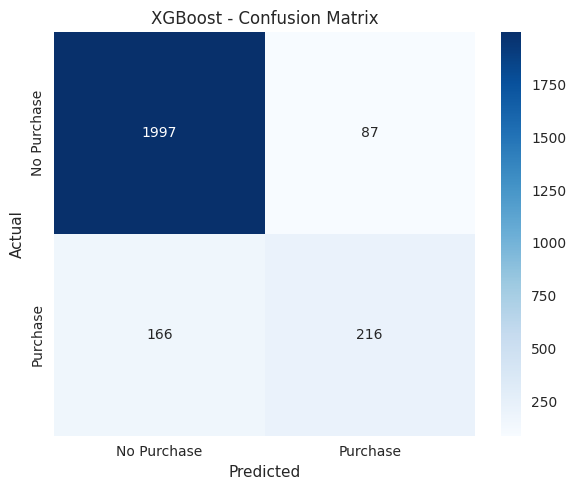

<Figure size 800x550 with 0 Axes>

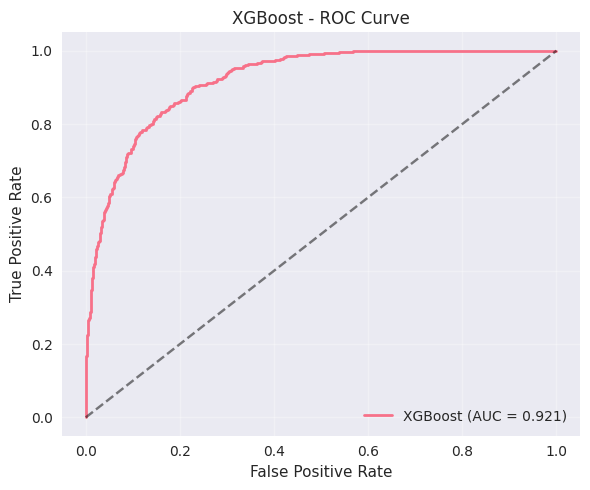

<Figure size 800x550 with 0 Axes>

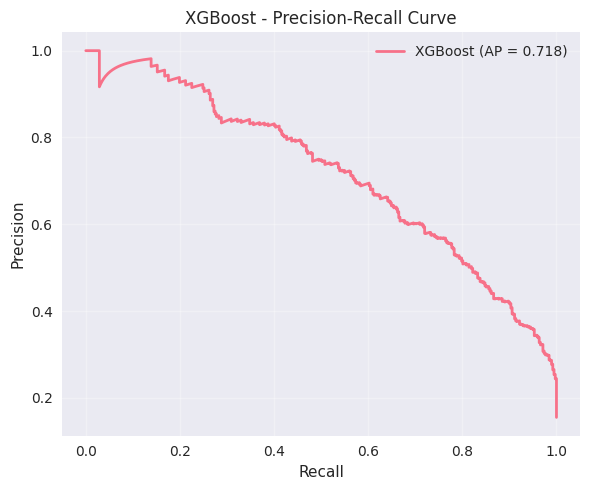

<Figure size 800x550 with 0 Axes>

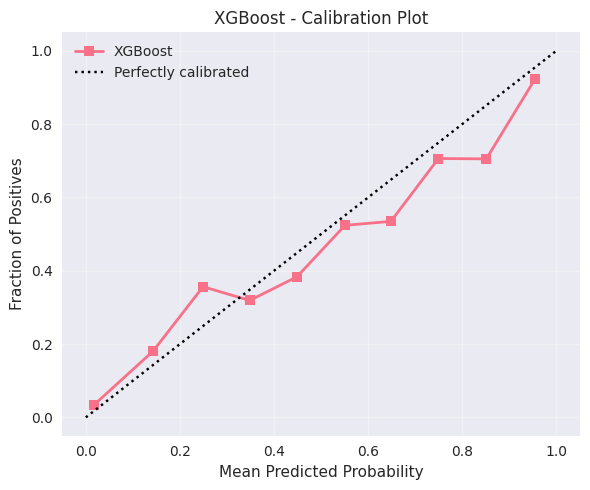

✅ XGBoost training completed

📊 XGBoost Results:
   Accuracy: 0.8974
   F1-Score: 0.6307
   Precision: 0.7129
   Recall: 0.5654
   ROC-AUC: 0.9212499120700224
   Training Time: 0.37s


<Figure size 800x550 with 0 Axes>

In [4]:
print("🌳 Training XGBoost...")

# XGBoost with optimized parameters for binary classification
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',  # Binary log loss
    use_label_encoder=False,
    objective='binary:logistic'  # Binary classification
)

# Evaluate with comprehensive metrics
xgb_results = evaluator.evaluate_model(
    xgb_model, "XGBoost", 
    X_train_scaled, X_test_scaled, y_train, y_test,
    X_val_scaled, y_val
)

models['XGBoost'] = xgb_model
print("✅ XGBoost training completed")

# Display XGBoost results
print(f"\n📊 XGBoost Results:")
print(f"   Accuracy: {xgb_results['accuracy']:.4f}")
print(f"   F1-Score: {xgb_results['f1']:.4f}")
print(f"   Precision: {xgb_results['precision']:.4f}")
print(f"   Recall: {xgb_results['recall']:.4f}")
print(f"   ROC-AUC: {xgb_results.get('auc_roc', 'N/A')}")
print(f"   Training Time: {xgb_results['train_time']:.2f}s")

## 2.4 TabPFN v2 Training

🧠 Training TabPFN v2...

Evaluating TabPFN v2

📊 Performance Metrics:
   Accuracy: 0.9011
   Balanced Accuracy: 0.7747
   Precision: 0.7197
   Recall: 0.5916
   F1-Score: 0.6494
   Matthews Correlation: 0.5963
   AUC-ROC: 0.9326
   Average Precision: 0.7533
   Log Loss: 0.2254
   Brier Score: 0.0702

⏱️  Timing:
   Training Time: 0.5356s
   Inference Time: 7.8345s
   Predictions/sec: 315

🔄 Cross-Validation:
   F1 Score: 0.6676 ± 0.0199


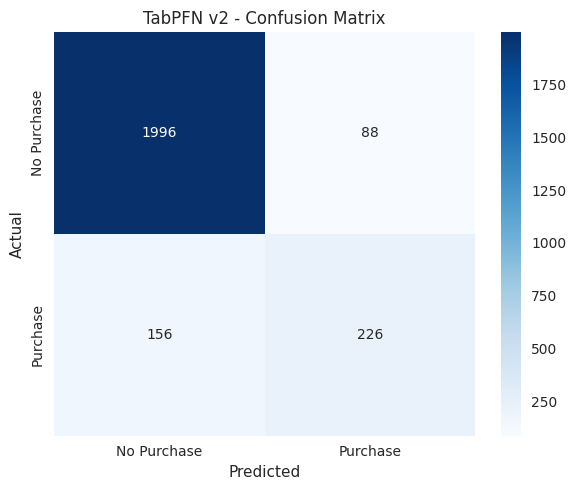

<Figure size 800x550 with 0 Axes>

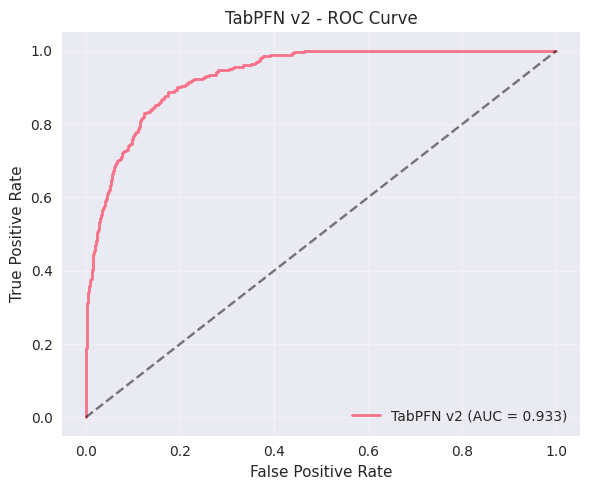

<Figure size 800x550 with 0 Axes>

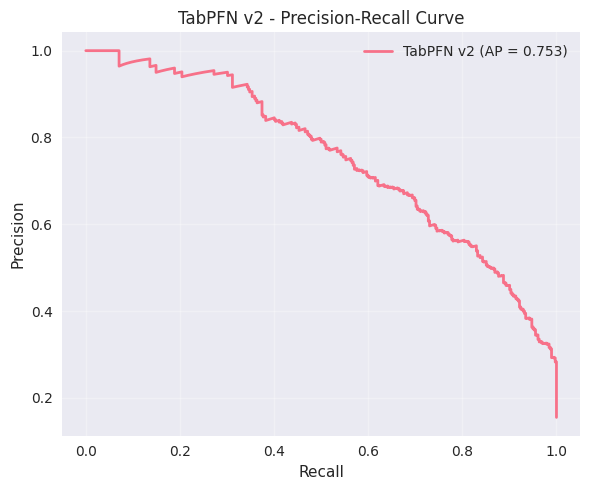

<Figure size 800x550 with 0 Axes>

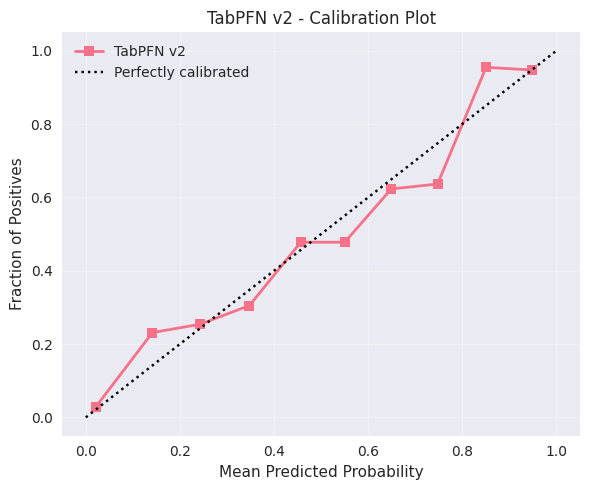

✅ TabPFN v2 training completed

📊 TabPFN v2 Results:
   Accuracy: 0.9011
   F1-Score: 0.6494
   Precision: 0.7197
   Recall: 0.5916
   ROC-AUC: 0.9325526826180021
   Training Time: 0.54s


<Figure size 800x550 with 0 Axes>

In [5]:
print("🧠 Training TabPFN v2...")

if TabPFNClassifier is not None:
    # Set environment variable for large datasets
    import os
    os.environ['TABPFN_ALLOW_CPU_LARGE_DATASET'] = '1'
    
    try:
        # TabPFN v2 - Prior-Fitted Networks (fixed parameters)
        tabpfn_model = TabPFNClassifier(
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )
        
        # Evaluate with comprehensive metrics
        tabpfn_results = evaluator.evaluate_model(
            tabpfn_model, "TabPFN v2", 
            X_train_scaled, X_test_scaled, y_train, y_test,
            X_val_scaled, y_val
        )
        
        models['TabPFN v2'] = tabpfn_model
        print("✅ TabPFN v2 training completed")
        
        # Display TabPFN results
        print(f"\n📊 TabPFN v2 Results:")
        print(f"   Accuracy: {tabpfn_results['accuracy']:.4f}")
        print(f"   F1-Score: {tabpfn_results['f1']:.4f}")
        print(f"   Precision: {tabpfn_results['precision']:.4f}")
        print(f"   Recall: {tabpfn_results['recall']:.4f}")
        print(f"   ROC-AUC: {tabpfn_results.get('auc_roc', 'N/A')}")
        print(f"   Training Time: {tabpfn_results['train_time']:.2f}s")
        
    except Exception as e:
        print(f"⚠️ TabPFN training failed: {e}")
        print("Continuing with other models...")
else:
    print("⚠️ TabPFN not available - skipping")

## 2.5 TabICL Training

🎯 Training TabICL...

Evaluating TabICL

📊 Performance Metrics:
   Accuracy: 0.8994
   Balanced Accuracy: 0.7705
   Precision: 0.7147
   Recall: 0.5838
   F1-Score: 0.6427
   Matthews Correlation: 0.5889
   AUC-ROC: 0.9340
   Average Precision: 0.7543
   Log Loss: 0.2227
   Brier Score: 0.0697

⏱️  Timing:
   Training Time: 0.5936s
   Inference Time: 11.3113s
   Predictions/sec: 218

🔄 Cross-Validation:
   F1 Score: 0.6665 ± 0.0245


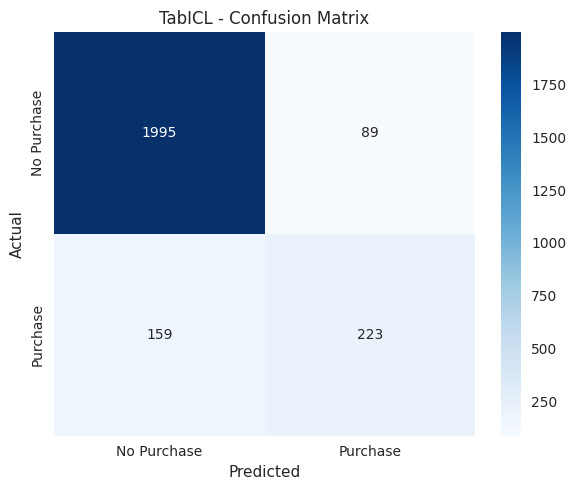

<Figure size 800x550 with 0 Axes>

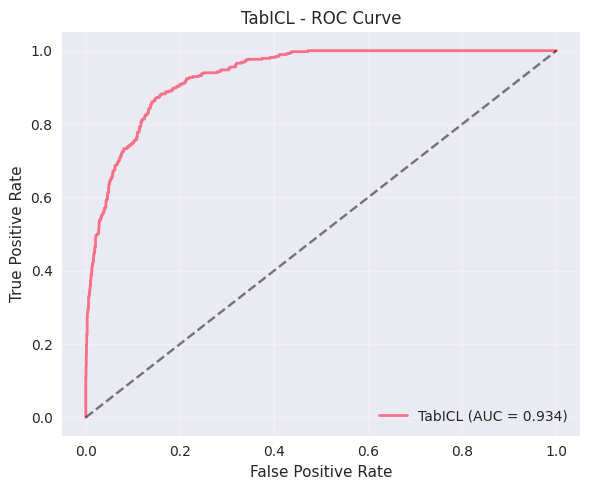

<Figure size 800x550 with 0 Axes>

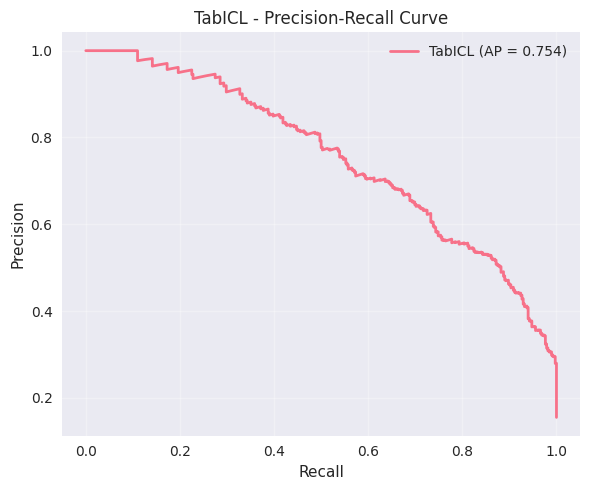

<Figure size 800x550 with 0 Axes>

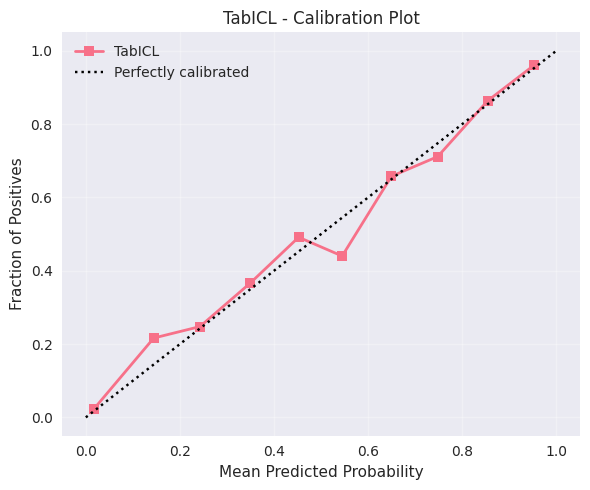

✅ TabICL training completed

📊 TabICL Results:
   Accuracy: 0.8994
   F1-Score: 0.6427
   Precision: 0.7147
   Recall: 0.5838
   ROC-AUC: 0.9339501411904212
   Training Time: 0.59s


<Figure size 800x550 with 0 Axes>

In [6]:
print("🎯 Training TabICL...")

if TabICLClassifier is not None:
    try:
        # TabICL - In-Context Learning for tabular data
        tabicl_model = TabICLClassifier(
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )
        
        # Evaluate with comprehensive metrics
        tabicl_results = evaluator.evaluate_model(
            tabicl_model, "TabICL", 
            X_train_scaled, X_test_scaled, y_train, y_test,
            X_val_scaled, y_val
        )
        
        models['TabICL'] = tabicl_model
        print("✅ TabICL training completed")
        
        # Display TabICL results
        print(f"\n📊 TabICL Results:")
        print(f"   Accuracy: {tabicl_results['accuracy']:.4f}")
        print(f"   F1-Score: {tabicl_results['f1']:.4f}")
        print(f"   Precision: {tabicl_results['precision']:.4f}")
        print(f"   Recall: {tabicl_results['recall']:.4f}")
        print(f"   ROC-AUC: {tabicl_results.get('auc_roc', 'N/A')}")
        print(f"   Training Time: {tabicl_results['train_time']:.2f}s")
        
    except Exception as e:
        print(f"⚠️ TabICL training failed: {e}")
        print("Continuing with other models...")
else:
    print("⚠️ TabICL not available - skipping")

## 2.6 FT-Transformer Training for Online Shoppers Classification

This notebook implements the **FT-Transformer (Feature Tokenizer + Transformer)** architecture for tabular data classification on the Online Shoppers Purchasing Intention dataset using the `rtdl` library.

## FT-Transformer Overview

The FT-Transformer is a Transformer-based architecture specifically designed for tabular data that:
- Converts numerical and categorical features into embeddings
- Uses attention mechanisms to capture feature interactions
- Applies layer normalization and residual connections
- Provides state-of-the-art performance on many tabular datasets

## Implementation Details

- **Feature Tokenization**: Each feature is converted to a token embedding
- **Positional Encoding**: Features get positional information
- **Multi-Head Attention**: Captures complex feature interactions
- **Feed-Forward Networks**: Non-linear transformations
- **Classification Head**: Final prediction layer for binary classification

**Reference**: Gorishniy, Y., Rubachev, I., Khrulkov, V., & Babenko, A. (2021). Revisiting Deep Learning Models for Tabular Data. arXiv preprint arXiv:2106.11959.

In [7]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# ML libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

# Import rtdl library for FT-Transformer
try:
    import rtdl
    print("✅ rtdl library imported successfully")
    print(f"rtdl version: {rtdl.__version__ if hasattr(rtdl, '__version__') else 'unknown'}")
except ImportError:
    print("❌ rtdl library not available. Install with: pip install rtdl")
    print("This notebook requires the rtdl library to run.")
    raise ImportError("Please install rtdl: pip install rtdl")

# Import our custom evaluation framework
try:
    from enhanced_evaluation import ComprehensiveEvaluator
    print("✅ Enhanced evaluation imported successfully")
except ImportError:
    print("⚠️ Enhanced evaluation not available. Using basic evaluation.")
    ComprehensiveEvaluator = None

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("🤖 FT-Transformer Training for Online Shoppers Classification")
print("Dataset: Online Shoppers Purchasing Intention")

✅ rtdl library imported successfully
rtdl version: 0.0.13
✅ Enhanced evaluation imported successfully
Using device: cuda
🤖 FT-Transformer Training for Online Shoppers Classification
Dataset: Online Shoppers Purchasing Intention


## Load Preprocessed Data

In [8]:
# Load preprocessed data from Section 1
import pickle

try:
    with open('./online_shoppers_preprocessed_data.pkl', 'rb') as f:
        preprocessing_data = pickle.load(f)
    
    # Extract variables
    X_train_scaled = preprocessing_data['X_train_scaled']
    X_val_scaled = preprocessing_data['X_val_scaled']
    X_test_scaled = preprocessing_data['X_test_scaled']
    y_train = preprocessing_data['y_train']
    y_val = preprocessing_data['y_val']
    y_test = preprocessing_data['y_test']
    feature_names = preprocessing_data['feature_names']
    month_mapping = preprocessing_data['month_mapping']
    visitor_mapping = preprocessing_data['visitor_mapping']
    data_summary = preprocessing_data['data_summary']
    
    print("✅ Preprocessed data loaded successfully!")
    print(f"Training set: {X_train_scaled.shape}")
    print(f"Validation set: {X_val_scaled.shape}")
    print(f"Test set: {X_test_scaled.shape}")
    print(f"Features: {len(feature_names)}")
    print(f"Classes: 2 (Binary Classification)")
    print(f"Class names: ['No Purchase', 'Purchase']")

    # After loading your preprocessed data, before moving to GPU
    print("\nChecking for invalid values...")
    print(f"NaN in X_train: {np.isnan(X_train_scaled).any()}")
    print(f"Inf in X_train: {np.isinf(X_train_scaled).any()}")
    print(f"NaN in y_train: {np.isnan(y_train).any()}")

    # Check data ranges
    print(f"X_train min: {X_train_scaled.min()}, max: {X_train_scaled.max()}")
    print(f"y_train min: {y_train.min()}, max: {y_train.max()}")
    
except FileNotFoundError:
    print("❌ Preprocessed data not found!")
    print("Please run Section 1 (Data Preprocessing) notebook first.")
    raise

# After loading preprocessed data, before tensor creation
import gc

# Clean up any existing GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

# Force garbage collection
gc.collect()

# Check GPU memory
if torch.cuda.is_available():
    print(f"\nGPU memory allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved()/1024**2:.2f} MB")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

print(f"\n📊 Data converted to PyTorch tensors on {device}")
print(f"Input features: {X_train_tensor.shape[1]}")
print(f"Number of classes: 2 (Binary Classification)")

# Get class names for visualization
class_names = ['No Purchase', 'Purchase']
n_features = X_train_tensor.shape[1]
n_classes = 2

✅ Preprocessed data loaded successfully!
Training set: (7891, 17)
Validation set: (1973, 17)
Test set: (2466, 17)
Features: 17
Classes: 2 (Binary Classification)
Class names: ['No Purchase', 'Purchase']

Checking for invalid values...
NaN in X_train: False
Inf in X_train: False
NaN in y_train: False
X_train min: -2.488996784845566, max: 32.206070260503154
y_train min: 0, max: 1

GPU memory allocated: 112.35 MB
GPU memory cached: 164.00 MB

📊 Data converted to PyTorch tensors on cuda
Input features: 17
Number of classes: 2 (Binary Classification)


## Data Preparation for FT-Transformer

In [9]:
# Prepare data for FT-Transformer
# FT-Transformer expects specific data format with feature information

# Since all features are numerical (after preprocessing), we treat them as continuous
# Create feature info for rtdl
feature_info = {
    'n_num_features': n_features,  # All features are numerical
    'n_cat_features': 0,           # No categorical features after preprocessing
    'cat_cardinalities': []        # Empty since no categorical features
}

print(f"📋 Feature Information:")
print(f"   Numerical features: {feature_info['n_num_features']}")
print(f"   Categorical features: {feature_info['n_cat_features']}")
print(f"   Feature names: {feature_names[:5]}... (showing first 5)")

# Create data loaders
batch_size = 256

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n🔄 Data loaders created:")
print(f"   Batch size: {batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

📋 Feature Information:
   Numerical features: 17
   Categorical features: 0
   Feature names: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated']... (showing first 5)

🔄 Data loaders created:
   Batch size: 256
   Train batches: 31
   Validation batches: 8
   Test batches: 10


## FT-Transformer Model Configuration

In [10]:
# FT-Transformer hyperparameters

# Training hyperparameters
training_config = {
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'n_epochs': 100,
    'patience': 15,  # Early stopping patience
    'min_delta': 1e-4  # Minimum improvement for early stopping
}

print("\n📚 Training Configuration:")
for key, value in training_config.items():
    print(f"   {key}: {value}")


📚 Training Configuration:
   learning_rate: 0.0001
   weight_decay: 1e-05
   n_epochs: 100
   patience: 15
   min_delta: 0.0001


## FT-Transformer Model Creation

In [11]:
# Create FT-Transformer using rtdl library
print("🤖 Creating FT-Transformer using rtdl library...")

fttransformer_model = rtdl.FTTransformer.make_default(
    n_num_features=feature_info['n_num_features'],
    cat_cardinalities=feature_info['cat_cardinalities'],
    d_out=n_classes
)

# Move model to device
fttransformer_model = fttransformer_model.to(device)

# Count parameters
total_params = sum(p.numel() for p in fttransformer_model.parameters())
trainable_params = sum(p.numel() for p in fttransformer_model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")
print(f"   Task: Binary Classification (Purchase Prediction)")

🤖 Creating FT-Transformer using rtdl library...

📊 Model Statistics:
   Total parameters: 898,562
   Trainable parameters: 898,562
   Model size: ~3.43 MB
   Task: Binary Classification (Purchase Prediction)


## Training Setup

In [12]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    fttransformer_model.parameters(), 
    lr=training_config['learning_rate'],
    weight_decay=training_config['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

print("🔧 Training setup completed:")
print(f"   Loss function: CrossEntropyLoss")
print(f"   Optimizer: AdamW (lr={training_config['learning_rate']}, wd={training_config['weight_decay']})")
print(f"   Scheduler: ReduceLROnPlateau")

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'learning_rates': []
}

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

🔧 Training setup completed:
   Loss function: CrossEntropyLoss
   Optimizer: AdamW (lr=0.0001, wd=1e-05)
   Scheduler: ReduceLROnPlateau


## Training Functions

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        # For rtdl FTTransformer, we need to pass data in the expected format
        # Since we only have numerical features, we pass None for categorical
        output = model(data, None)  # (numerical_features, categorical_features)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def validate_epoch(model, val_loader, criterion, device):
    """Validate the model for one epoch"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            
            # For rtdl FTTransformer, we need to pass data in the expected format
            output = model(data, None)  # (numerical_features, categorical_features)
            
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

print("✅ Training functions defined")

✅ Training functions defined


## Training Loop

In [14]:
print("🚀 Starting FT-Transformer training...")
print(f"Training for {training_config['n_epochs']} epochs with early stopping (patience={training_config['patience']})")
print("-" * 80)

start_time = time.time()

for epoch in range(training_config['n_epochs']):
    # Training
    train_loss, train_acc = train_epoch(fttransformer_model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc = validate_epoch(fttransformer_model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(current_lr)
    
    # Early stopping check
    if val_loss < best_val_loss - training_config['min_delta']:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = fttransformer_model.state_dict().copy()
        best_epoch = epoch
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch < 5:
        print(f"Epoch {epoch+1:3d}/{training_config['n_epochs']} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"LR: {current_lr:.2e} | Patience: {patience_counter}/{training_config['patience']}")
    
    # Early stopping
    if patience_counter >= training_config['patience']:
        print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}")
        print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}")
        break

training_time = time.time() - start_time

# Load best model
if best_model_state is not None:
    fttransformer_model.load_state_dict(best_model_state)
    print(f"\n✅ Loaded best model from epoch {best_epoch+1}")

print(f"\n🏁 Training completed in {training_time:.2f} seconds")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final validation accuracy: {history['val_acc'][best_epoch]:.2f}%")

🚀 Starting FT-Transformer training...
Training for 100 epochs with early stopping (patience=15)
--------------------------------------------------------------------------------
Epoch   1/100 | Train Loss: 0.3718 | Train Acc: 85.39% | Val Loss: 0.2712 | Val Acc: 88.60% | LR: 1.00e-04 | Patience: 0/15
Epoch   2/100 | Train Loss: 0.2663 | Train Acc: 89.49% | Val Loss: 0.2390 | Val Acc: 89.51% | LR: 1.00e-04 | Patience: 0/15
Epoch   3/100 | Train Loss: 0.2593 | Train Acc: 89.51% | Val Loss: 0.2462 | Val Acc: 89.71% | LR: 1.00e-04 | Patience: 1/15
Epoch   4/100 | Train Loss: 0.2463 | Train Acc: 89.81% | Val Loss: 0.2309 | Val Acc: 89.61% | LR: 1.00e-04 | Patience: 0/15
Epoch   5/100 | Train Loss: 0.2456 | Train Acc: 90.05% | Val Loss: 0.2325 | Val Acc: 89.71% | LR: 1.00e-04 | Patience: 1/15
Epoch  10/100 | Train Loss: 0.2321 | Train Acc: 90.42% | Val Loss: 0.2214 | Val Acc: 89.96% | LR: 1.00e-04 | Patience: 0/15
Epoch  20/100 | Train Loss: 0.2175 | Train Acc: 90.82% | Val Loss: 0.2231 | Val

## Training Visualization

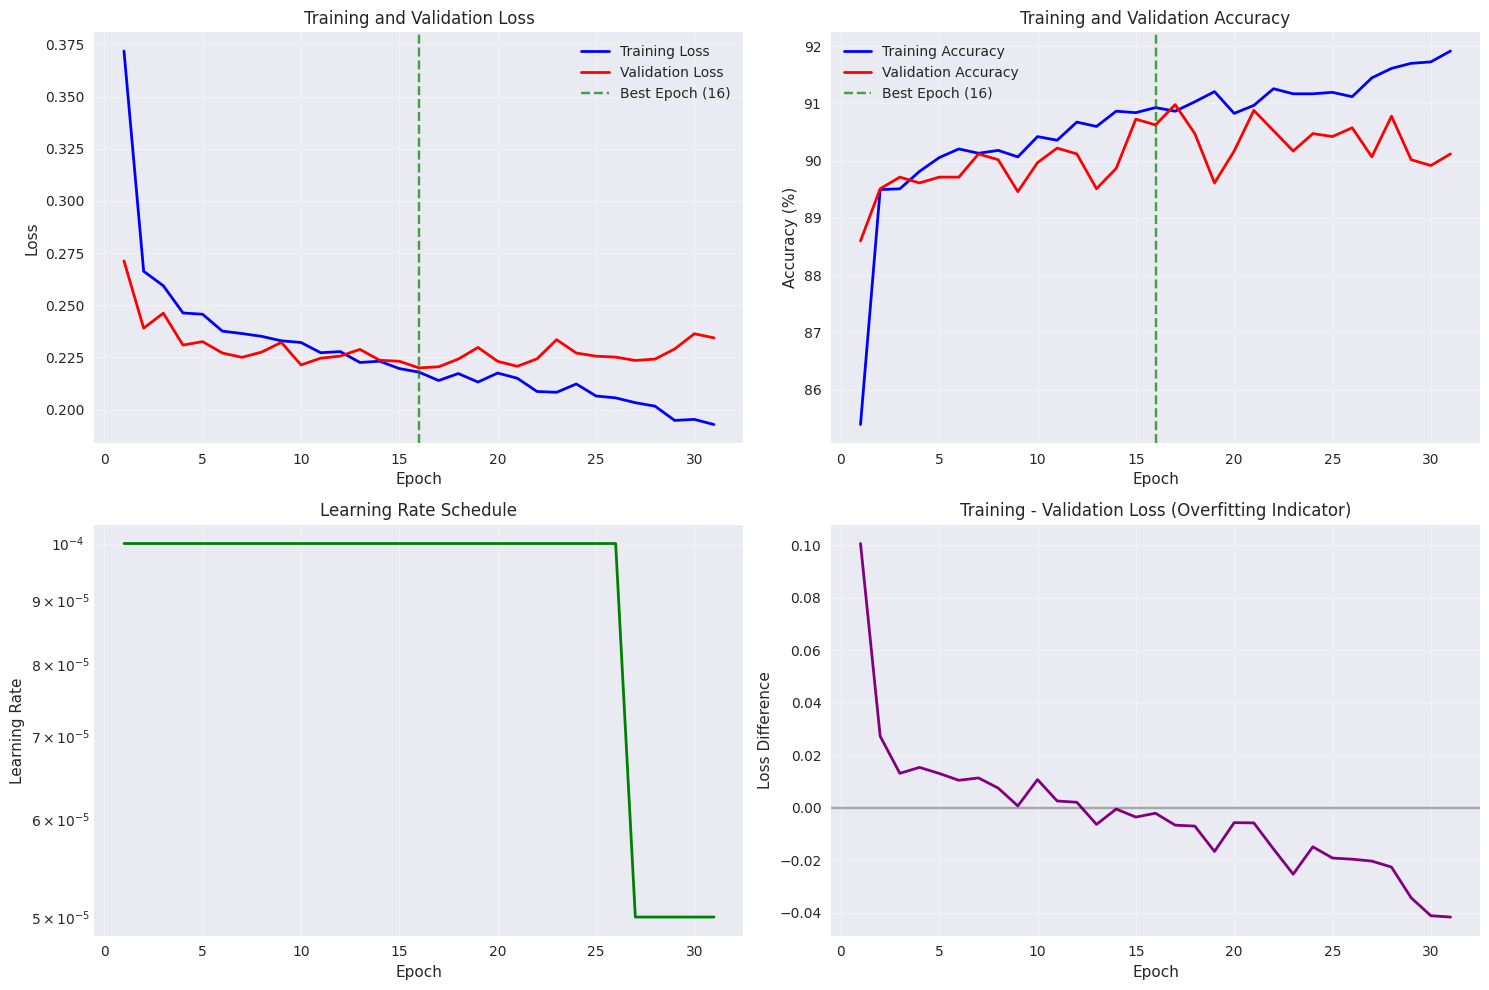


📈 Training Summary:
   Total epochs: 31
   Best epoch: 16
   Best validation loss: 0.2199
   Training time: 17.90 seconds
   Final learning rate: 5.00e-05


In [15]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(history['train_loss']) + 1)

# Loss curves
axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0, 0].axvline(x=best_epoch+1, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch+1})')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
axes[0, 1].axvline(x=best_epoch+1, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch+1})')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate schedule
axes[1, 0].plot(epochs, history['learning_rates'], 'g-', linewidth=2)
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Loss difference (overfitting indicator)
loss_diff = np.array(history['train_loss']) - np.array(history['val_loss'])
axes[1, 1].plot(epochs, loss_diff, 'purple', linewidth=2)
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].set_title('Training - Validation Loss (Overfitting Indicator)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss Difference')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./Section2_Model_Training/FT_Transformer_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📈 Training Summary:")
print(f"   Total epochs: {len(history['train_loss'])}")
print(f"   Best epoch: {best_epoch+1}")
print(f"   Best validation loss: {best_val_loss:.4f}")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Final learning rate: {history['learning_rates'][-1]:.2e}")

## Initialize Enhanced Evaluator

In [31]:
# Initialize the comprehensive evaluator
# evaluator = ComprehensiveEvaluator()

print(fttransformer_model)
models['FT-Transformer'] = fttransformer_model
# Create PyTorch model wrapper for the FT-Transformer
ft_wrapper = evaluator.create_pytorch_wrapper(
    model=fttransformer_model,
    device=device,
    batch_size=256
)
print(ft_wrapper)

print("✅ Enhanced evaluator initialized")
print("✅ FT-Transformer wrapper created")
print(f"   Device: {device}")
print(f"   Batch size: 256")

FTTransformer(
  (feature_tokenizer): FeatureTokenizer(
    (num_tokenizer): NumericalFeatureTokenizer()
  )
  (cls_token): CLSToken()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): ModuleDict(
        (attention): MultiheadAttention(
          (W_q): Linear(in_features=192, out_features=192, bias=True)
          (W_k): Linear(in_features=192, out_features=192, bias=True)
          (W_v): Linear(in_features=192, out_features=192, bias=True)
          (W_out): Linear(in_features=192, out_features=192, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (ffn): FFN(
          (linear_first): Linear(in_features=192, out_features=512, bias=True)
          (activation): ReGLU()
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_second): Linear(in_features=256, out_features=192, bias=True)
        )
        (attention_residual_dropout): Dropout(p=0.0, inplace=False)
        (ffn_residual_dropout): Dropout(p=0.0, inplace=False)


## Comprehensive Model Evaluation

This section performs a complete evaluation of the FT-Transformer model using the enhanced evaluation framework.

🚀 Starting comprehensive FT-Transformer evaluation...
This may take a few minutes depending on your hardware.

Evaluating FT-Transformer
ℹ️ Skipping cross-validation for PyTorch model (already trained)

📊 Performance Metrics:
   Accuracy: 0.8958
   Balanced Accuracy: 0.7812
   Precision: 0.6812
   Recall: 0.6152
   F1-Score: 0.6465
   Matthews Correlation: 0.5866
   AUC-ROC: 0.9220
   Average Precision: 0.7335
   Log Loss: 0.2432
   Brier Score: 0.0740

⏱️  Timing:
   Training Time: 0.0000s
   Inference Time: 0.0448s
   Predictions/sec: 54986


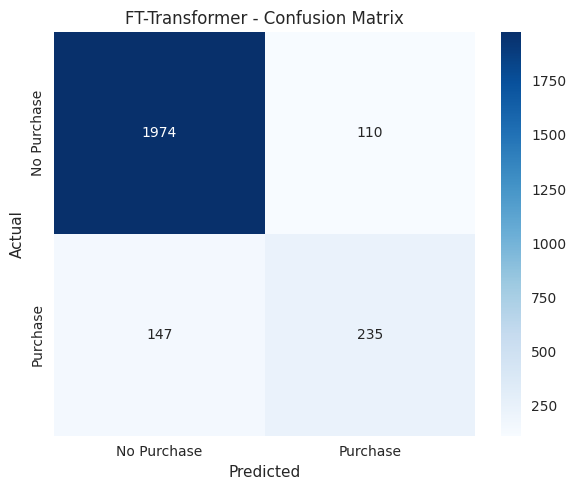

<Figure size 800x550 with 0 Axes>

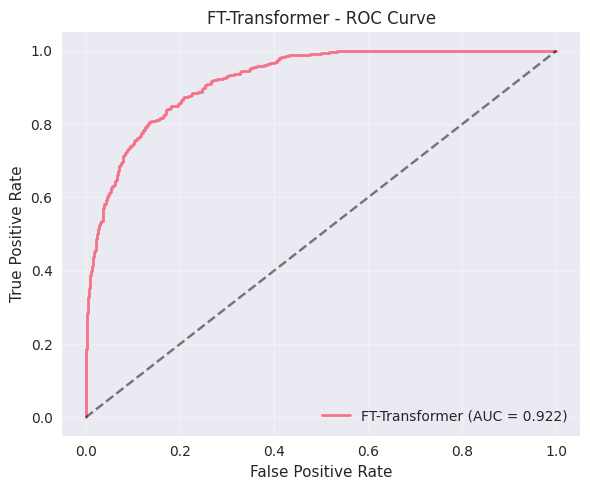

<Figure size 800x550 with 0 Axes>

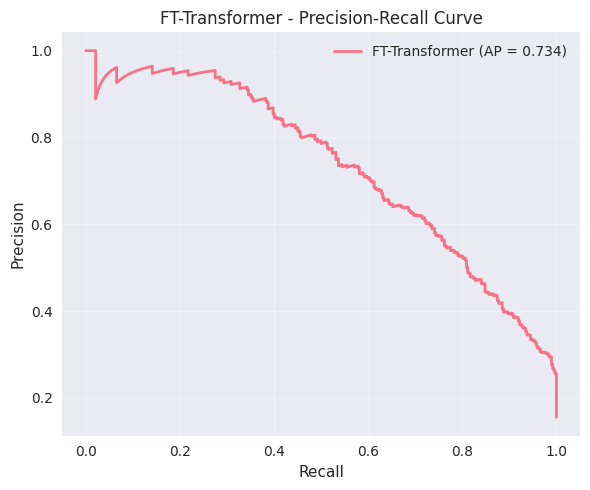

<Figure size 800x550 with 0 Axes>

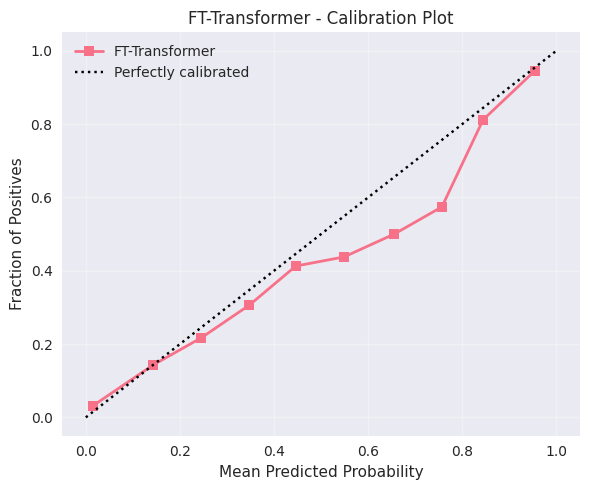


✅ FT-Transformer evaluation completed!


<Figure size 800x550 with 0 Axes>

In [18]:
# Perform comprehensive evaluation
print("🚀 Starting comprehensive FT-Transformer evaluation...")
print("This may take a few minutes depending on your hardware.")

# Evaluate the FT-Transformer model
ft_results = evaluator.evaluate_model(
    model=ft_wrapper,
    model_name="FT-Transformer",
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    y_train=y_train,
    y_test=y_test,
    X_val=X_val_scaled,
    y_val=y_val,
    predict_proba_available=True
)

print("\n✅ FT-Transformer evaluation completed!")

## Detailed Results Analysis

In [19]:
# Display detailed results
print("📊 DETAILED FT-TRANSFORMER RESULTS")
print("=" * 60)

# Create results DataFrame for better visualization
results_df = pd.DataFrame([ft_results]).T
results_df.columns = ['FT-Transformer']

# Performance metrics
performance_metrics = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'mcc']
if 'auc_roc' in results_df.index:
    performance_metrics.append('auc_roc')
if 'log_loss' in results_df.index:
    performance_metrics.append('log_loss')

print("\n🎯 Performance Metrics:")
performance_df = results_df.loc[performance_metrics]
for metric in performance_metrics:
    if metric in results_df.index:
        value = results_df.loc[metric, 'FT-Transformer']
        print(f"   {metric.replace('_', ' ').title()}: {value:.4f}")

# Timing metrics
timing_metrics = ['train_time', 'inference_time', 'predictions_per_second']
print("\n⏱️ Timing Metrics:")
for metric in timing_metrics:
    if metric in results_df.index:
        value = results_df.loc[metric, 'FT-Transformer']
        if metric == 'predictions_per_second':
            print(f"   {metric.replace('_', ' ').title()}: {value:.0f}")
        else:
            print(f"   {metric.replace('_', ' ').title()}: {value:.4f}s")

# Cross-validation metrics (if available)
if 'cv_f1_mean' in results_df.index:
    print("\n🔄 Cross-Validation:")
    cv_mean = results_df.loc['cv_f1_mean', 'FT-Transformer']
    cv_std = results_df.loc['cv_f1_std', 'FT-Transformer']
    print(f"   F1 Score: {cv_mean:.4f} ± {cv_std:.4f}")

📊 DETAILED FT-TRANSFORMER RESULTS

🎯 Performance Metrics:
   Accuracy: 0.8958
   Balanced Accuracy: 0.7812
   Precision: 0.6812
   Recall: 0.6152
   F1: 0.6465
   Mcc: 0.5866
   Auc Roc: 0.9220
   Log Loss: 0.2432

⏱️ Timing Metrics:
   Train Time: 0.0000s
   Inference Time: 0.0448s
   Predictions Per Second: 54986


## Model Performance Summary

In [20]:
# Create a comprehensive summary
print("📈 FT-TRANSFORMER PERFORMANCE SUMMARY")
print("=" * 50)

# Get predictions for additional analysis
y_pred = ft_wrapper.predict(X_test_scaled)
y_proba = ft_wrapper.predict_proba(X_test_scaled)

# Per-class analysis for binary classification
from sklearn.metrics import precision_recall_fscore_support, classification_report

precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, y_pred, average=None
)

print("\n📋 Per-Class Performance:")
print("-" * 70)
print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 70)

for i, class_name in enumerate(class_names):
    print(f"{class_name:<15} {precision_per_class[i]:<10.4f} "
          f"{recall_per_class[i]:<10.4f} {f1_per_class[i]:<10.4f} "
          f"{support_per_class[i]:<10.0f}")

# Binary classification specific metrics
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n🎯 Binary Classification Metrics:")
print(f"   True Negatives (Correct No Purchase): {tn}")
print(f"   False Positives (Incorrect Purchase): {fp}")
print(f"   False Negatives (Missed Purchase): {fn}")
print(f"   True Positives (Correct Purchase): {tp}")
print(f"   Sensitivity (True Positive Rate): {tp/(tp+fn):.4f}")
print(f"   Specificity (True Negative Rate): {tn/(tn+fp):.4f}")
print(f"   False Positive Rate: {fp/(fp+tn):.4f}")
print(f"   False Negative Rate: {fn/(fn+tp):.4f}")

# Overall assessment
overall_accuracy = ft_results['accuracy']
overall_f1 = ft_results['f1']
roc_auc = ft_results.get('auc_roc', 'N/A')

print(f"\n🎯 Overall Assessment:")
if overall_accuracy > 0.9:
    print(f"   Excellent performance (Accuracy: {overall_accuracy:.4f})")
elif overall_accuracy > 0.8:
    print(f"   Good performance (Accuracy: {overall_accuracy:.4f})")
elif overall_accuracy > 0.7:
    print(f"   Moderate performance (Accuracy: {overall_accuracy:.4f})")
else:
    print(f"   Needs improvement (Accuracy: {overall_accuracy:.4f})")

print(f"   Weighted F1-Score: {overall_f1:.4f}")
if roc_auc != 'N/A':
    print(f"   ROC-AUC: {roc_auc:.4f}")
print(f"   Model complexity: {total_params:,} parameters")
print(f"   Inference speed: {ft_results['predictions_per_second']:.0f} predictions/second")

# Business insights for online shoppers
print(f"\n💼 Business Insights:")
if precision_per_class[1] > 0.8:  # Purchase class precision
    print(f"   ✅ High purchase precision ({precision_per_class[1]:.4f}) - Low false positive rate")
    print(f"   📊 Good for targeted marketing campaigns")
if recall_per_class[1] > 0.8:  # Purchase class recall
    print(f"   ✅ High purchase recall ({recall_per_class[1]:.4f}) - Captures most potential buyers")
    print(f"   📊 Good for maximizing revenue opportunities")
if tp/(tp+fn) > 0.7:  # Sensitivity
    print(f"   ✅ Good sensitivity - Identifies most customers likely to purchase")
if tn/(tn+fp) > 0.8:  # Specificity
    print(f"   ✅ Good specificity - Avoids targeting unlikely customers")

📈 FT-TRANSFORMER PERFORMANCE SUMMARY

📋 Per-Class Performance:
----------------------------------------------------------------------
Class           Precision  Recall     F1-Score   Support   
----------------------------------------------------------------------
No Purchase     0.9307     0.9472     0.9389     2084      
Purchase        0.6812     0.6152     0.6465     382       

🎯 Binary Classification Metrics:
   True Negatives (Correct No Purchase): 1974
   False Positives (Incorrect Purchase): 110
   False Negatives (Missed Purchase): 147
   True Positives (Correct Purchase): 235
   Sensitivity (True Positive Rate): 0.6152
   Specificity (True Negative Rate): 0.9472
   False Positive Rate: 0.0528
   False Negative Rate: 0.3848

🎯 Overall Assessment:
   Good performance (Accuracy: 0.8958)
   Weighted F1-Score: 0.6465
   ROC-AUC: 0.9220
   Model complexity: 898,562 parameters
   Inference speed: 54986 predictions/second

💼 Business Insights:
   ✅ Good specificity - Avoids targetin

## ROC and Precision-Recall Analysis

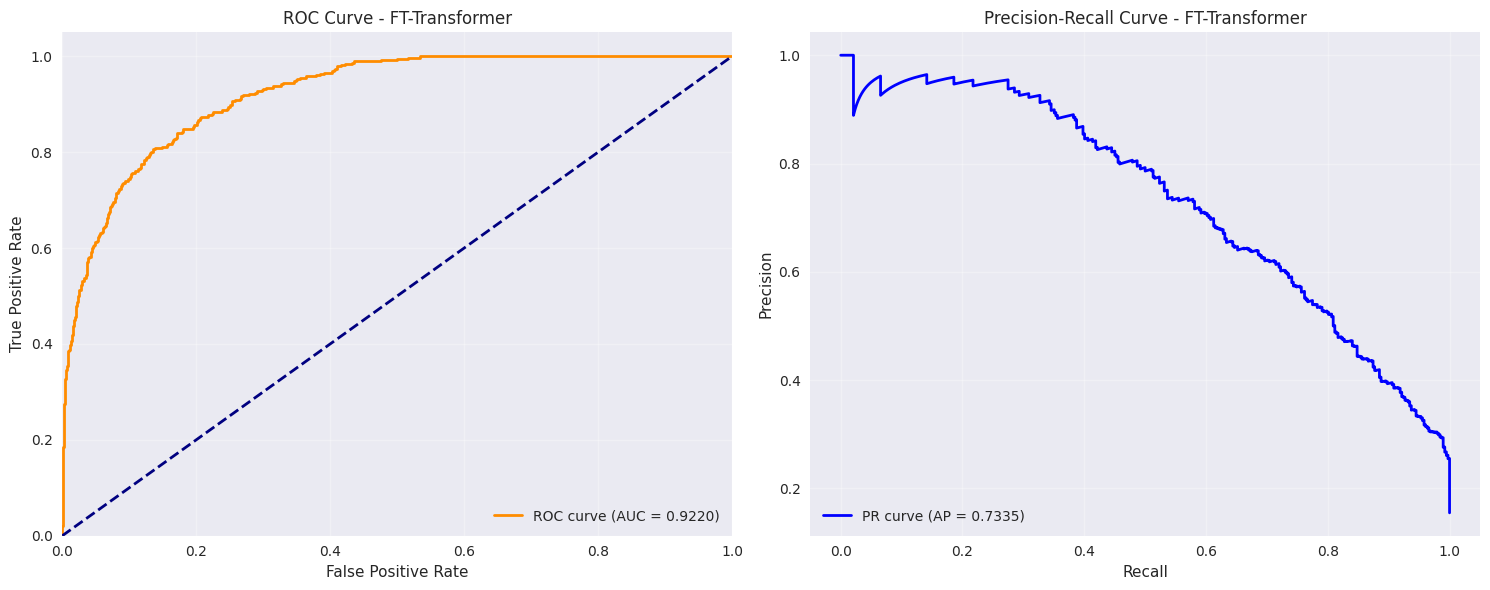


📈 Curve Analysis:
   ROC-AUC: 0.9220 - Excellent discrimination
   Average Precision: 0.7335 - Good precision-recall trade-off


In [21]:
# ROC and Precision-Recall curves for binary classification
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - FT-Transformer')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba[:, 1])
avg_precision = average_precision_score(y_test, y_proba[:, 1])
axes[1].plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve - FT-Transformer')
axes[1].legend(loc="lower left")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./Section2_Model_Training/FT_Transformer_roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📈 Curve Analysis:")
print(f"   ROC-AUC: {roc_auc:.4f} - {'Excellent' if roc_auc > 0.9 else 'Good' if roc_auc > 0.8 else 'Moderate'} discrimination")
print(f"   Average Precision: {avg_precision:.4f} - {'Excellent' if avg_precision > 0.8 else 'Good' if avg_precision > 0.6 else 'Moderate'} precision-recall trade-off")

## Save Evaluation Results

In [23]:
# Save evaluation results
print("💾 Saving evaluation results...")

# Save detailed results
results_df.to_csv('./Section2_Model_Training/ft_transformer_evaluation_results.csv')
print("✅ Detailed results saved to './Section2_Model_Training/ft_transformer_evaluation_results.csv'")

# Save per-class results
per_class_results = pd.DataFrame({
    'Class': class_names,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support_per_class
})
per_class_results.to_csv('./Section2_Model_Training/ft_transformer_per_class_results.csv', index=False)
print("✅ Per-class results saved to './Section2_Model_Training/ft_transformer_per_class_results.csv'")

# Save predictions for further analysis
predictions_df = pd.DataFrame({
    'true_labels': y_test,
    'predicted_labels': y_pred,
    'max_probability': np.max(y_proba, axis=1),
    'prob_no_purchase': y_proba[:, 0],
    'prob_purchase': y_proba[:, 1]
})

predictions_df.to_csv('./Section2_Model_Training/ft_transformer_predictions.csv', index=False)
print("✅ Predictions saved to './Section2_Model_Training/ft_transformer_predictions.csv'")

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv('./Section2_Model_Training/ft_transformer_training_history.csv', index=False)
print("✅ Training history saved to './Section2_Model_Training/ft_transformer_training_history.csv'")

# Save model state (optional - can be large)
torch.save({
    'model_state_dict': fttransformer_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'training_config': training_config,
    'feature_info': feature_info,
    'best_epoch': best_epoch,
    'best_val_loss': best_val_loss,
    'total_params': total_params
}, './Section2_Model_Training/ft_transformer_model.pth')
print("✅ Model checkpoint saved to './Section2_Model_Training/ft_transformer_model.pth'")

print("\n🎉 FT-Transformer evaluation completed successfully!")
print("\n📁 Generated files:")
print("   - ft_transformer_evaluation_results.csv")
print("   - ft_transformer_per_class_results.csv")
print("   - ft_transformer_predictions.csv")
print("   - ft_transformer_training_history.csv")
print("   - ft_transformer_model.pth")
print("   - FT_Transformer_training_history.png")
print("   - FT_Transformer_roc_pr_curves.png")

💾 Saving evaluation results...
✅ Detailed results saved to './Section2_Model_Training/ft_transformer_evaluation_results.csv'
✅ Per-class results saved to './Section2_Model_Training/ft_transformer_per_class_results.csv'
✅ Predictions saved to './Section2_Model_Training/ft_transformer_predictions.csv'
✅ Training history saved to './Section2_Model_Training/ft_transformer_training_history.csv'
✅ Model checkpoint saved to './Section2_Model_Training/ft_transformer_model.pth'

🎉 FT-Transformer evaluation completed successfully!

📁 Generated files:
   - ft_transformer_evaluation_results.csv
   - ft_transformer_per_class_results.csv
   - ft_transformer_predictions.csv
   - ft_transformer_training_history.csv
   - ft_transformer_model.pth
   - FT_Transformer_training_history.png
   - FT_Transformer_roc_pr_curves.png


## Final Summary

In [24]:
# Final comprehensive summary
print("\n" + "="*80)
print("FT-TRANSFORMER TRAINING COMPLETION SUMMARY")
print("="*80)
print(f"✅ Model Successfully Trained: FT-Transformer")
print(f"\n📊 Training Statistics:")
print(f"   Total Parameters: {total_params:,}")
print(f"   Training Time: {training_time:.2f} seconds")
print(f"   Best Epoch: {best_epoch+1}")
print(f"   Final Validation Accuracy: {history['val_acc'][best_epoch]:.2f}%")
print(f"\n🎯 Performance Metrics:")
print(f"   Test Accuracy: {overall_accuracy:.4f}")
print(f"   F1-Score: {overall_f1:.4f}")
print(f"   ROC-AUC: {roc_auc if roc_auc != 'N/A' else 'N/A'}")
print(f"   Precision (Purchase): {precision_per_class[1]:.4f}")
print(f"   Recall (Purchase): {recall_per_class[1]:.4f}")
print(f"\n💼 Business Impact:")
print(f"   Purchase Prediction Accuracy: {f1_per_class[1]:.4f} F1-Score")
print(f"   False Positive Rate: {fp/(fp+tn)*100:.2f}%")
print(f"   False Negative Rate: {fn/(fn+tp)*100:.2f}%")
print(f"\n🎯 Dataset: Online Shoppers Purchasing Intention")
print(f"📊 Task: Binary Classification (Purchase Prediction)")
print(f"🔢 Features: {len(feature_names)}")
print(f"📈 Training Samples: {len(X_train_scaled):,}")
print(f"🧪 Test Samples: {len(X_test_scaled):,}")
print(f"\n🚀 Model ready for deployment and integration with other models!")


FT-TRANSFORMER TRAINING COMPLETION SUMMARY
✅ Model Successfully Trained: FT-Transformer

📊 Training Statistics:
   Total Parameters: 898,562
   Training Time: 17.90 seconds
   Best Epoch: 16
   Final Validation Accuracy: 90.62%

🎯 Performance Metrics:
   Test Accuracy: 0.8958
   F1-Score: 0.6465
   ROC-AUC: 0.9219910361668558
   Precision (Purchase): 0.6812
   Recall (Purchase): 0.6152

💼 Business Impact:
   Purchase Prediction Accuracy: 0.6465 F1-Score
   False Positive Rate: 5.28%
   False Negative Rate: 38.48%

🎯 Dataset: Online Shoppers Purchasing Intention
📊 Task: Binary Classification (Purchase Prediction)
🔢 Features: 17
📈 Training Samples: 7,891
🧪 Test Samples: 2,466

🚀 Model ready for deployment and integration with other models!


In [25]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# ML libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

# Import rtdl library for FT-Transformer
try:
    import rtdl
    print("✅ rtdl library imported successfully")
    print(f"rtdl version: {rtdl.__version__ if hasattr(rtdl, '__version__') else 'unknown'}")
except ImportError:
    print("❌ rtdl library not available. Install with: pip install rtdl")
    print("This notebook requires the rtdl library to run.")
    raise ImportError("Please install rtdl: pip install rtdl")

# Import our custom evaluation framework
try:
    from enhanced_evaluation import ComprehensiveEvaluator
    print("✅ Enhanced evaluation imported successfully")
except ImportError:
    print("⚠️ Enhanced evaluation not available. Using basic evaluation.")
    ComprehensiveEvaluator = None

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("🤖 FT-Transformer Training for Online Shoppers Classification")
print("Dataset: Online Shoppers Purchasing Intention")

✅ rtdl library imported successfully
rtdl version: 0.0.13
✅ Enhanced evaluation imported successfully
Using device: cuda
🤖 FT-Transformer Training for Online Shoppers Classification
Dataset: Online Shoppers Purchasing Intention


## 2.7 Comprehensive Model Comparison

📊 COMPREHENSIVE MODEL COMPARISON

MODEL COMPARISON SUMMARY
                accuracy        f1 precision    recall       mcc   auc_roc
XGBoost         0.897405  0.630657  0.712871  0.565445  0.577181   0.92125
TabPFN v2       0.901054  0.649425  0.719745  0.591623  0.596322  0.932553
TabICL          0.899432  0.642651  0.714744   0.58377  0.588882   0.93395
FT-Transformer  0.895783  0.646492  0.681159  0.615183  0.586605  0.921991

TIMING COMPARISON
               train_time inference_time predictions_per_second
XGBoost          0.345126       0.003304          746474.715935
TabPFN v2        0.535606       7.834489             314.762069
TabICL           0.593583      11.311253             218.012986
FT-Transformer   0.000002       0.044847           54986.356824


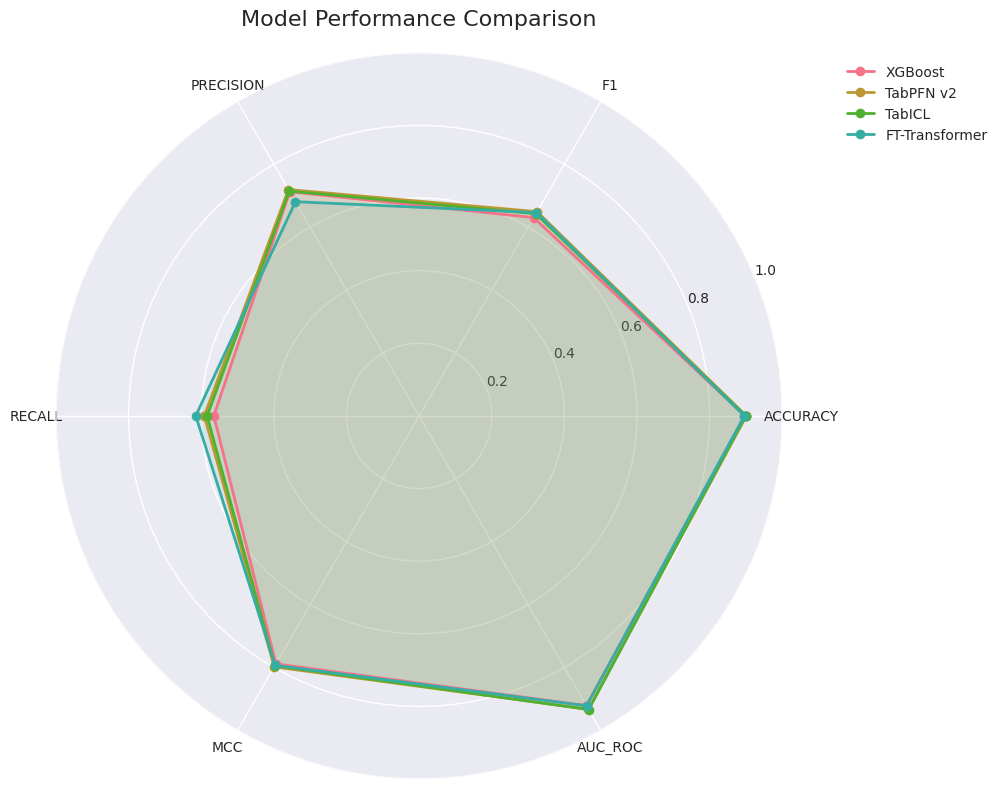

<Figure size 800x550 with 0 Axes>

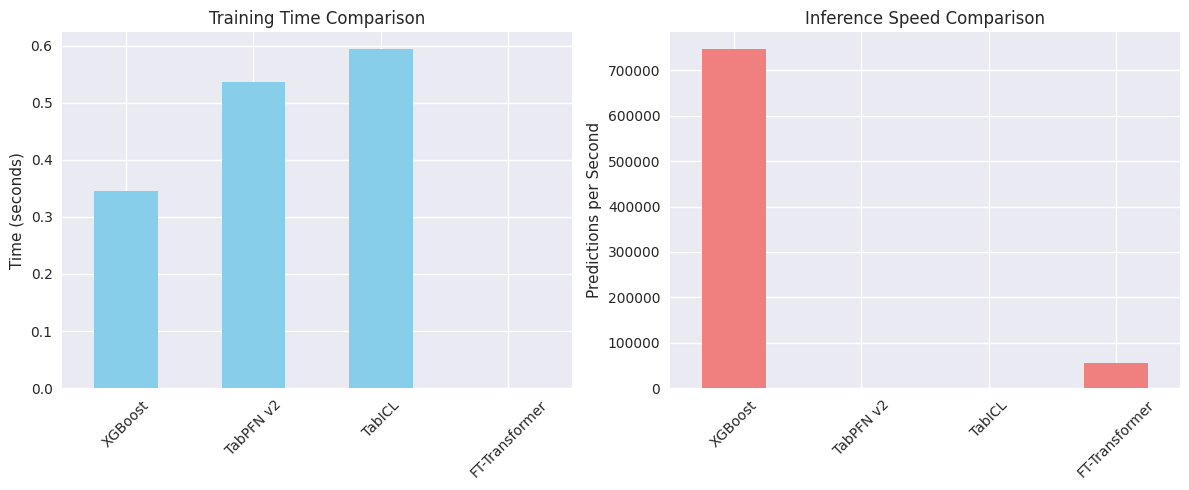


DETAILED PERFORMANCE COMPARISON
                    model_name  accuracy balanced_accuracy precision    recall        f1       mcc train_time inference_time predictions_per_second   auc_roc avg_precision  log_loss brier_score cv_f1_mean cv_f1_std
XGBoost                XGBoost  0.897405          0.761849  0.712871  0.565445  0.630657  0.577181   0.345126       0.003304          746474.715935   0.92125      0.717805  0.247605     0.07583   0.633772  0.020686
TabPFN v2            TabPFN v2  0.901054          0.774698  0.719745  0.591623  0.649425  0.596322   0.535606       7.834489             314.762069  0.932553      0.753285  0.225356    0.070177   0.667581  0.019888
TabICL                  TabICL  0.899432          0.770532  0.714744   0.58377  0.642651  0.588882   0.593583      11.311253             218.012986   0.93395      0.754274  0.222694    0.069713   0.666521  0.024492
FT-Transformer  FT-Transformer  0.895783            0.7812  0.681159  0.615183  0.646492  0.586605   0.0000

<Figure size 800x550 with 0 Axes>

In [26]:
# Generate comprehensive comparison
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)

comparison_df = evaluator.compare_models()

if comparison_df is not None:
    # Display detailed comparison table
    print("\n" + "="*100)
    print("DETAILED PERFORMANCE COMPARISON")
    print("="*100)
    print(comparison_df.round(4).to_string())
    
    # Save comparison results
    comparison_df.to_csv('./Section2_Model_Training/online_shoppers_model_comparison.csv', index=True)
    print("\n💾 Comparison results saved to './Section2_Model_Training/online_shoppers_model_comparison.csv'")
else:
    print("❌ Not enough models for comparison")

## 2.7 Class Imbalance Analysis

In [27]:
# Analyze performance on different classes
print("\n" + "="*60)
print("CLASS IMBALANCE ANALYSIS")
print("="*60)

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

class_analysis_results = []

for model_name, model in models.items():
    print(f"\n📊 {model_name} - Per-Class Performance:")
    
    if hasattr(model, 'predict'):
        y_pred = model.predict(X_test_scaled)
        
        # Per-class metrics
        precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
        
        # Create per-class results table
        class_results = pd.DataFrame({
            'Class': class_names,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Support': support
        })
        
        print(class_results.round(4).to_string(index=False))
        
        # Confusion matrix analysis
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        print(f"\nConfusion Matrix Analysis:")
        print(f"  True Negatives (Correct No Purchase): {tn}")
        print(f"  False Positives (Incorrect Purchase): {fp}")
        print(f"  False Negatives (Missed Purchase): {fn}")
        print(f"  True Positives (Correct Purchase): {tp}")
        print(f"  Sensitivity (True Positive Rate): {tp/(tp+fn):.4f}")
        print(f"  Specificity (True Negative Rate): {tn/(tn+fp):.4f}")
        print(f"  False Positive Rate: {fp/(fp+tn):.4f}")
        print(f"  False Negative Rate: {fn/(fn+tp):.4f}")
        
        # Store results for comparison
        class_analysis_results.append({
            'Model': model_name,
            'No_Purchase_Precision': precision[0],
            'No_Purchase_Recall': recall[0],
            'No_Purchase_F1': f1[0],
            'Purchase_Precision': precision[1],
            'Purchase_Recall': recall[1],
            'Purchase_F1': f1[1],
            'Sensitivity_TPR': tp/(tp+fn),
            'Specificity_TNR': tn/(tn+fp),
            'FPR': fp/(fp+tn),
            'FNR': fn/(fn+tp)
        })
        
        # Save per-class results
        class_results.to_csv(f'./Section2_Model_Training/{model_name}_per_class_results.csv', index=False)
        print(f"💾 Per-class results saved to 'online_shoppers/Section2_Model_Training/{model_name}_per_class_results.csv'")

# Create comprehensive class analysis comparison
if class_analysis_results:
    class_analysis_df = pd.DataFrame(class_analysis_results)
    class_analysis_df.to_csv('./Section2_Model_Training/class_imbalance_analysis.csv', index=False)
    print(f"\n💾 Class imbalance analysis saved to 'online_shoppers/Section2_Model_Training/class_imbalance_analysis.csv'")


CLASS IMBALANCE ANALYSIS

📊 XGBoost - Per-Class Performance:
      Class  Precision  Recall  F1-Score  Support
No Purchase     0.9233  0.9583    0.9404     2084
   Purchase     0.7129  0.5654    0.6307      382

Confusion Matrix Analysis:
  True Negatives (Correct No Purchase): 1997
  False Positives (Incorrect Purchase): 87
  False Negatives (Missed Purchase): 166
  True Positives (Correct Purchase): 216
  Sensitivity (True Positive Rate): 0.5654
  Specificity (True Negative Rate): 0.9583
  False Positive Rate: 0.0417
  False Negative Rate: 0.4346
💾 Per-class results saved to 'online_shoppers/Section2_Model_Training/XGBoost_per_class_results.csv'

📊 TabPFN v2 - Per-Class Performance:
      Class  Precision  Recall  F1-Score  Support
No Purchase     0.9275  0.9578    0.9424     2084
   Purchase     0.7197  0.5916    0.6494      382

Confusion Matrix Analysis:
  True Negatives (Correct No Purchase): 1996
  False Positives (Incorrect Purchase): 88
  False Negatives (Missed Purchase): 15

## 2.8 Error Analysis


ERROR ANALYSIS
Total misclassified samples: 253 out of 2466
Misclassification rate: 10.26%


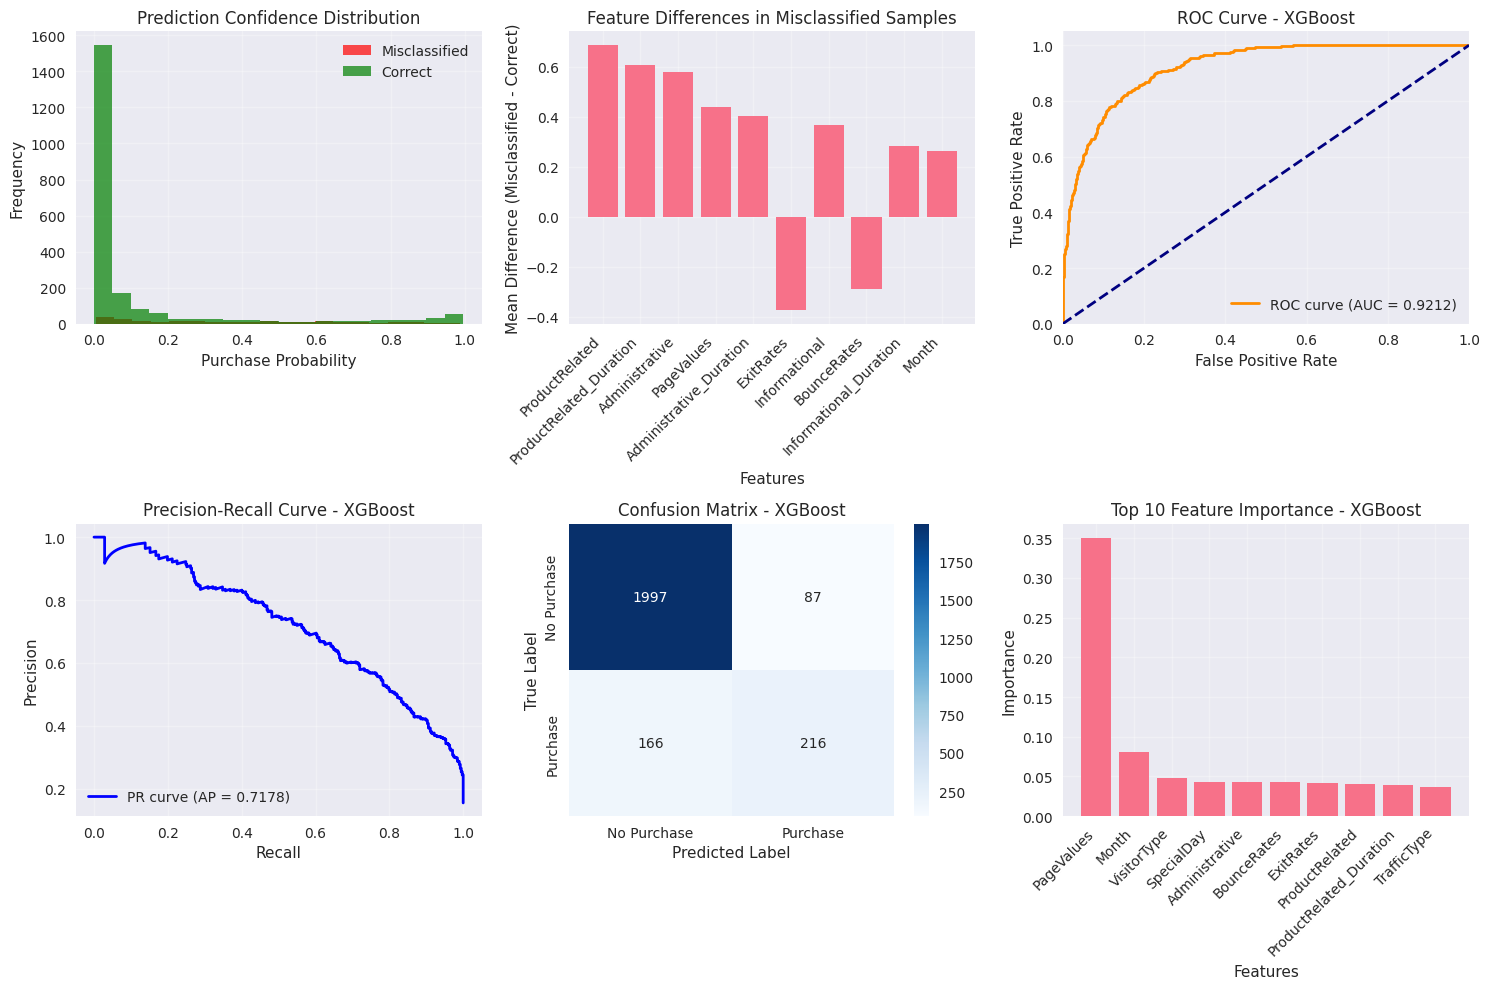


Top 5 features with largest differences in misclassified samples:
   1. ProductRelated: 0.6888
   2. ProductRelated_Duration: 0.6073
   3. Administrative: 0.5784
   4. PageValues: 0.4411
   5. Administrative_Duration: 0.4041

Top 5 most important features (XGBoost):
   1. PageValues: 0.3505
   2. Month: 0.0806
   3. VisitorType: 0.0480
   4. SpecialDay: 0.0436
   5. Administrative: 0.0433


In [28]:
# Analyze misclassified samples
print("\n" + "="*60)
print("ERROR ANALYSIS")
print("="*60)

# Focus on XGBoost for detailed error analysis
if 'XGBoost' in models:
    xgb_pred = models['XGBoost'].predict(X_test_scaled)
    xgb_proba = models['XGBoost'].predict_proba(X_test_scaled)[:, 1]  # Probability of purchase
    
    # Find misclassified samples
    misclassified_mask = (xgb_pred != y_test)
    misclassified_indices = np.where(misclassified_mask)[0]
    
    print(f"Total misclassified samples: {len(misclassified_indices)} out of {len(y_test)}")
    print(f"Misclassification rate: {len(misclassified_indices)/len(y_test)*100:.2f}%")
    
    # Analyze confidence of misclassified samples
    misclassified_proba = xgb_proba[misclassified_mask]
    correct_proba = xgb_proba[~misclassified_mask]
    
    plt.figure(figsize=(15, 10))
    
    # Confidence distribution
    plt.subplot(2, 3, 1)
    plt.hist(misclassified_proba, bins=20, alpha=0.7, label='Misclassified', color='red')
    plt.hist(correct_proba, bins=20, alpha=0.7, label='Correct', color='green')
    plt.xlabel('Purchase Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Confidence Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Feature importance for misclassified samples
    plt.subplot(2, 3, 2)
    misclassified_features = X_test_scaled[misclassified_mask]
    correct_features = X_test_scaled[~misclassified_mask]
    
    feature_diff = np.mean(misclassified_features, axis=0) - np.mean(correct_features, axis=0)
    sorted_indices = np.argsort(np.abs(feature_diff))[::-1][:10]
    
    plt.bar(range(10), feature_diff[sorted_indices])
    plt.xlabel('Features')
    plt.ylabel('Mean Difference (Misclassified - Correct)')
    plt.title('Feature Differences in Misclassified Samples')
    plt.xticks(range(10), [feature_names[i] for i in sorted_indices], rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # ROC Curve
    plt.subplot(2, 3, 3)
    fpr, tpr, _ = roc_curve(y_test, xgb_proba)
    roc_auc = roc_auc_score(y_test, xgb_proba)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - XGBoost')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    plt.subplot(2, 3, 4)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, xgb_proba)
    avg_precision = average_precision_score(y_test, xgb_proba)
    plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - XGBoost')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    
    # Confusion Matrix Heatmap
    plt.subplot(2, 3, 5)
    cm = confusion_matrix(y_test, xgb_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - XGBoost')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Feature importance from XGBoost
    plt.subplot(2, 3, 6)
    feature_importance = models['XGBoost'].feature_importances_
    sorted_importance_indices = np.argsort(feature_importance)[::-1][:10]
    plt.bar(range(10), feature_importance[sorted_importance_indices])
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Top 10 Feature Importance - XGBoost')
    plt.xticks(range(10), [feature_names[i] for i in sorted_importance_indices], rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('./Section2_Model_Training/error_analysis_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nTop 5 features with largest differences in misclassified samples:")
    for i, idx in enumerate(sorted_indices[:5]):
        print(f"   {i+1}. {feature_names[idx]}: {feature_diff[idx]:.4f}")
    
    print(f"\nTop 5 most important features (XGBoost):")
    for i, idx in enumerate(sorted_importance_indices[:5]):
        print(f"   {i+1}. {feature_names[idx]}: {feature_importance[idx]:.4f}")

## 2.9 Model Performance Summary

In [29]:
# Create comprehensive summary
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)

summary_data = []
for model_name, results in evaluator.results.items():
    summary_data.append({
        'Model': model_name,
        'Accuracy': f"{results['accuracy']:.4f}",
        'F1-Score': f"{results['f1']:.4f}",
        'Precision': f"{results['precision']:.4f}",
        'Recall': f"{results['recall']:.4f}",
        'ROC-AUC': f"{results.get('auc_roc', 'N/A')}",
        'Training_Time': f"{results['train_time']:.2f}s",
        'Inference_Speed': f"{results['predictions_per_second']:.0f} pred/s"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Identify best performing model
if evaluator.results:
    best_model = max(evaluator.results.items(), key=lambda x: x[1]['f1'])
    print(f"\n🏆 Best performing model: {best_model[0]} (F1-Score: {best_model[1]['f1']:.4f})")
    
    # Additional insights for binary classification
    best_results = best_model[1]
    print(f"\n📈 Best Model Insights:")
    print(f"   Model: {best_model[0]}")
    print(f"   Accuracy: {best_results['accuracy']:.4f}")
    print(f"   Precision: {best_results['precision']:.4f}")
    print(f"   Recall: {best_results['recall']:.4f}")
    print(f"   F1-Score: {best_results['f1']:.4f}")
    if 'auc_roc' in best_results:
        print(f"   ROC-AUC: {best_results['auc_roc']:.4f}")
    print(f"   Training Time: {best_results['train_time']:.2f}s")
    print(f"   Inference Speed: {best_results['predictions_per_second']:.0f} predictions/second")
    
    # Business insights
    print(f"\n💼 Business Insights:")
    if best_results['precision'] > 0.8:
        print(f"   ✅ High precision ({best_results['precision']:.4f}) - Low false positive rate")
        print(f"   📊 Good for targeted marketing campaigns")
    if best_results['recall'] > 0.8:
        print(f"   ✅ High recall ({best_results['recall']:.4f}) - Captures most potential buyers")
        print(f"   📊 Good for maximizing revenue opportunities")
    
    # Save summary
    summary_df.to_csv('./Section2_Model_Training/online_shoppers_model_summary.csv', index=False)
    print("\n💾 Model summary saved to 'online_shoppers/Section2_Model_Training/online_shoppers_model_summary.csv'")

else:
    print("\n⚠️ No models were successfully trained")

print(f"\n✅ Section 2 completed successfully!")
print(f"📁 Ready for explainability analysis in Section 3")
print(f"\n📊 Models trained: {list(models.keys())}")
print(f"📈 Total training samples: {len(X_train_scaled):,}")
print(f"🎯 Task: Binary Classification (Purchase Prediction)")


MODEL PERFORMANCE SUMMARY
         Model Accuracy F1-Score Precision Recall            ROC-AUC Training_Time Inference_Speed
       XGBoost   0.8974   0.6307    0.7129 0.5654 0.9212499120700224         0.35s   746475 pred/s
     TabPFN v2   0.9011   0.6494    0.7197 0.5916 0.9325526826180021         0.54s      315 pred/s
        TabICL   0.8994   0.6427    0.7147 0.5838 0.9339501411904212         0.59s      218 pred/s
FT-Transformer   0.8958   0.6465    0.6812 0.6152 0.9219910361668558         0.00s    54986 pred/s

🏆 Best performing model: TabPFN v2 (F1-Score: 0.6494)

📈 Best Model Insights:
   Model: TabPFN v2
   Accuracy: 0.9011
   Precision: 0.7197
   Recall: 0.5916
   F1-Score: 0.6494
   ROC-AUC: 0.9326
   Training Time: 0.54s
   Inference Speed: 315 predictions/second

💼 Business Insights:

💾 Model summary saved to 'online_shoppers/Section2_Model_Training/online_shoppers_model_summary.csv'

✅ Section 2 completed successfully!
📁 Ready for explainability analysis in Section 3

📊 M

In [32]:
# Save trained models and results for Section 3
import pickle

# Save all necessary variables for Section 3
section2_data = {
    'models': models,
    'evaluator': evaluator,
    'X_train_scaled': X_train_scaled,
    'X_val_scaled': X_val_scaled,
    'X_test_scaled': X_test_scaled,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'feature_names': feature_names,
    'month_mapping': month_mapping,
    'visitor_mapping': visitor_mapping,
    'class_names': class_names,
    'label_encoder_month': label_encoder_month,
    'label_encoder_visitor': label_encoder_visitor,
    'scaler': scaler,
    'data_summary': data_summary,
    'comparison_df': comparison_df if 'comparison_df' in locals() else None
}

# Save to pickle file
with open('./online_shoppers_section2_results.pkl', 'wb') as f:
    pickle.dump(section2_data, f)

print("💾 Section 2 results saved to 'online_shoppers/online_shoppers_section2_results.pkl'")
print("📋 This file contains all trained models and results for Section 3")

# Display final summary
print("\n" + "="*80)
print("SECTION 2 COMPLETION SUMMARY")
print("="*80)
print(f"✅ Models Successfully Trained: {len(models)}")
for model_name in models.keys():
    print(f"   - {model_name}")
print(f"\n📁 Files Generated:")
print(f"   - Model comparison CSV")
print(f"   - Per-class results for each model")
print(f"   - Class imbalance analysis")
print(f"   - Error analysis dashboard (PNG)")
print(f"   - Model summary CSV")
print(f"   - Section 2 results pickle file")
print(f"\n🎯 Dataset: Online Shoppers Purchasing Intention")
print(f"📊 Task: Binary Classification")
print(f"🔢 Features: {len(feature_names)}")
print(f"📈 Training Samples: {len(X_train_scaled):,}")
print(f"🧪 Test Samples: {len(X_test_scaled):,}")

💾 Section 2 results saved to 'online_shoppers/online_shoppers_section2_results.pkl'
📋 This file contains all trained models and results for Section 3

SECTION 2 COMPLETION SUMMARY
✅ Models Successfully Trained: 4
   - XGBoost
   - TabPFN v2
   - TabICL
   - FT-Transformer

📁 Files Generated:
   - Model comparison CSV
   - Per-class results for each model
   - Class imbalance analysis
   - Error analysis dashboard (PNG)
   - Model summary CSV
   - Section 2 results pickle file

🎯 Dataset: Online Shoppers Purchasing Intention
📊 Task: Binary Classification
🔢 Features: 17
📈 Training Samples: 7,891
🧪 Test Samples: 2,466
